# Testing Snake creation and evolution
Much (but not all) of this code will be duplicated to [main.py](../main.py)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import tsnake.initialize as init
from tsnake.snake import TSnake, Element, Node
from tsnake.grid import Grid, Point
from tsnake.utils import dist, seg_intersect


## Load images, compute masked reigons
### Link to images I used for the plane are [here](https://drive.google.com/open?id=1TK6rc-USD4KKI0Bss_B6r4l13oAD2uqG)

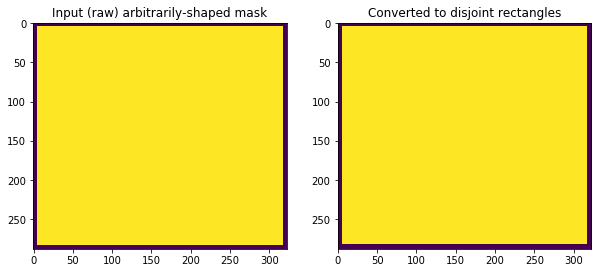

number of masked regions: 1


In [2]:
# msk_path = '../examples/places2/case1_mask.png'
# img_path = '../examples/places2/case1_raw.png'
img_path = '../examples/test/circle.png'

# mask = init.load_mask(path=msk_path, convert=True)
image = init.load_grayscale_image(img_path)
mask = np.zeros_like(image)
mask[5:-5, 5:-5] = 1

regions = init._find_disjoint_masked_regions(mask)
# NOTE: Uncomment to visialize initial masked reigons
init.visualize_masked_regions(mask, regions)

regions = init.compute_masked_regions(image, mask)
print('number of masked regions:', len(regions))


## Initialize t-snakes
_Note: Length 17 t-snake (i.e. the sort one) is visibly wrong, not sure how we can fix that_
*Legend*
* Green lines: Normal vectors
* White Nodes: Initial 5 nodes of the snake
* Yellow Nodes: Final 5 nodes of the snake
    * This tells us which way the snake was initialized, Counter Clockwise or Clockwise

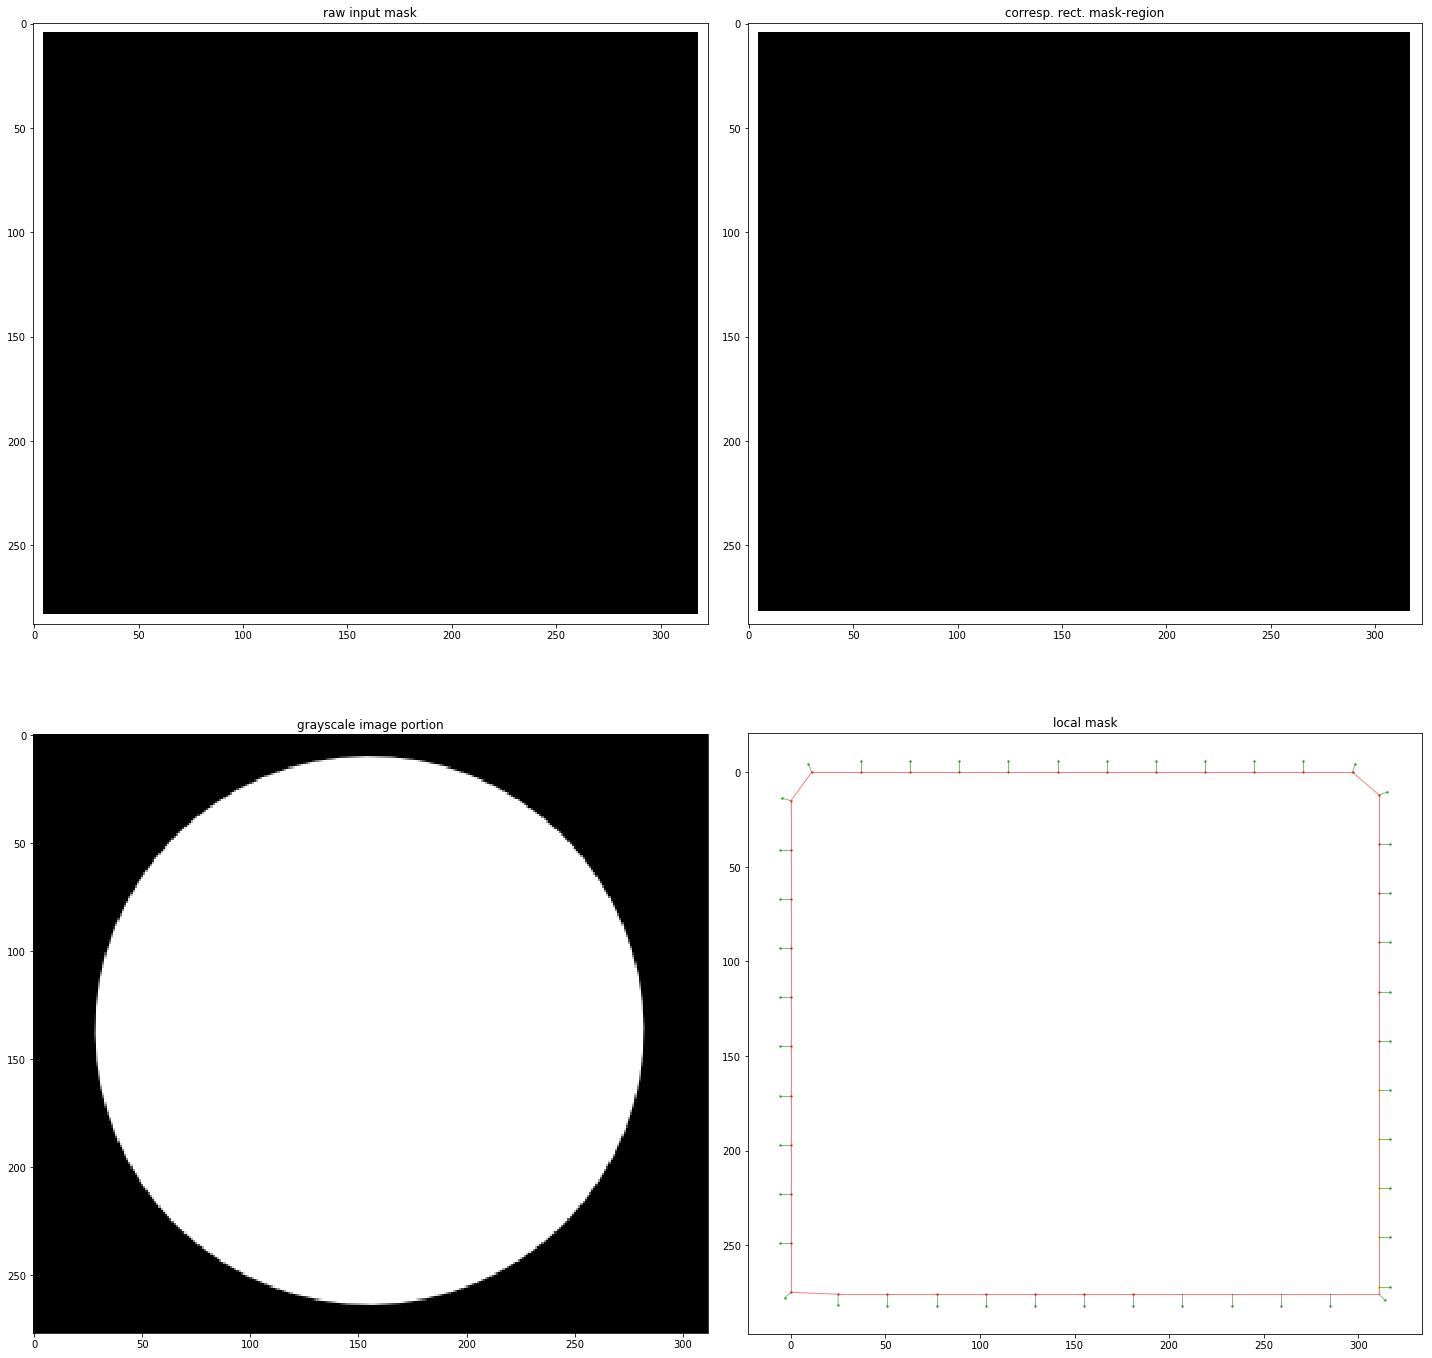

Length of T-Snakes initialized on image:
[46]


In [3]:
### Parameters for T-snakes ### 
N = 45           # 30 nodes
p = 0.002        # scale for Eq (7)
c = 10.0         # scale for Eq (A.4)
a = 17.5         # tension param in Eq (8)
b = 35.0         # bending param in Eq (8)
q = 30.0         # scale for Eq (4)
gamma = 4.0      # friction param in Eq (8)
dt = 0.08        # step size in Eq (8)
sigma = 1.0      # gaussian filter param in Eq (A.4)
threshold = 15

# region = compute_masked_regions(image, mask)[0]
# region.initialize_tsnake(N, p, c, sigma, a, b, q, gamma, dt, threshold)
# region.visualize()

# snake = region._initial_tsnake

tsnakes = []

for region in regions:
    tsnake = region.initialize_tsnake(
        N=N, p=p, c=c, sigma=sigma, a=a, b=b, q=q, gamma=gamma,
        dt=dt, threshold=threshold
    )
    tsnakes.append(tsnake)
    region.visualize() # NOTE: To show tsnakes on images, uncomment

# tsnakes.sort(key=lambda t: len(t.nodes))
t_snake_lengths = [len(t.nodes) for t in tsnakes]
print('Length of T-Snakes initialized on image:\n{}'.format(t_snake_lengths))

## Create Grid

In [4]:
image = init.load_grayscale_image(img_path)
print('image shape: ', image.shape)
acid_grid = Grid(image=image, scale=1)

# Update grid
# NOTE: Uncomment for force, expensive calculation
acid_grid.get_image_force(sigma=sigma, c=c, p=p)
acid_grid.get_inflation_force(threshold=threshold)
acid_grid.gen_simplex_grid()
print('Simplex grid shape: {}'.format(acid_grid.grid.shape))


image shape:  (288, 323)
Simplex grid shape: (288, 323)


## Test snake evolution

In [5]:
iterations = 1
target_region = 0
M = 10


region = regions[target_region]
for i in tqdm(range(iterations)):
    region_snake = tsnakes[target_region]
    # Run:
    # 1) the m-step function (which has M deformation steps), and
    # 2) the reparameterization (occuring every M deformation steps)
    region.show_snake(snake=region_snake, save_fig='reparam/iter{}.0.png'.format(i))
    
    print(len(region_snake.nodes))
    region_snake.m_step(M)
    region.show_snake(snake=region_snake,save_fig='reparam/iter{}.1.png'.format(i))
    
    new_region_snakes = acid_grid.reparameterize_phase_one([region_snake])
    tsnakes[target_region] = new_region_snakes[0]
    region.show_snake(snake=tsnakes[target_region], save_fig='reparam/iter{}.2.png'.format(i))
    print(len(new_region_snakes[0].nodes))
    

46
Intersections:
[(258.468, 283.532), (258.195, 284.0), (267.49, 267.51), (267.341, 268.0), (272.918, 249.082), (272.793, 250.0), (275.7, 227.3), (275.686, 228.314), (275.69, 228.0), (276.0, 205.0), (276.0, 180.0), (276.0, 155.0), (276.0, 129.0), (275.926, 104.0), (275.933, 104.067), (273.524, 81.0), (273.615, 81.385), (273.425, 80.575), (268.374, 59.626), (268.541, 60.0), (260.0, 41.327), (259.743, 41.0), (260.296, 41.704), (259.856, 41.144), (247.67, 26.0), (248.0, 26.247), (247.859, 26.141), (231.644, 14.356), (232.0, 14.508), (232.345, 14.655), (213.339, 6.661), (214.0, 6.808), (192.298, 2.0), (192.024, 1.976), (192.0, 1.974), (169.0, 0.0), (144.0, 0.0), (120.0, 0.001), (120.029, 0.0), (119.999, 0.001), (95.0, 0.72), (94.151, 0.849), (95.33, 0.67), (72.809, 4.191), (73.422, 4.0), (73.0, 4.132), (53.0, 10.418), (52.046, 10.954), (34.876, 21.0), (35.0, 20.881), (21.0, 34.889), (21.547, 34.0), (11.0, 51.917), (11.314, 51.0), (11.479, 50.521), (4.775, 70.225), (4.813, 70.0), (1.034, 9

## Test Intersection Computation

In [6]:
print('shape of tsnakes:', np.shape(tsnakes))

# Compute snake intersections with grid
intersections = acid_grid.get_snake_intersections(tsnakes)
print('intersections shape:', np.shape(intersections))

n_inter_for_each_t_snake = [len(inter) for inter in intersections]
print('num of intersections for each t-snake:', n_inter_for_each_t_snake)


shape of tsnakes: (1,)
intersections shape: (1, 192)
num of intersections for each t-snake: [192]


In [7]:
# print(intersections[0])